In [1]:
using Flux, Zygote, Distributions, Plots, StatsPlots, CSV, DataFrames, Random, LaTeXStrings

In [2]:
#https://de.finance.yahoo.com/quote/%5EGDAXI/history?period1=1515801600&period2=1673568000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = CSV.File("GDAXI.csv") |> DataFrame

a_close_raw = df[!,"Adj Close"]
a_close_nonull = a_close_raw[a_close_raw.!= "null"]
a_close = parse.(Float32, a_close_nonull)

returns = diff(log.(a_close))

train = returns[1:end-99]
test = returns[end-99:end]

100-element Vector{Float32}:
  0.0039186478
 -0.022901535
 -0.0060682297
  0.0052719116
 -0.009783745
 -0.016078949
  0.032715797
 -0.022432327
  0.008634567
  0.0034532547
 -0.0009021759
  0.014149666
  0.023712158
  ⋮
 -0.00497818
  0.010438919
 -0.010582924
  0.010407448
  0.007958412
  0.021562576
 -0.0037660599
  0.011960983
  0.012434959
 -0.0012331009
  0.01166153
  0.0073575974

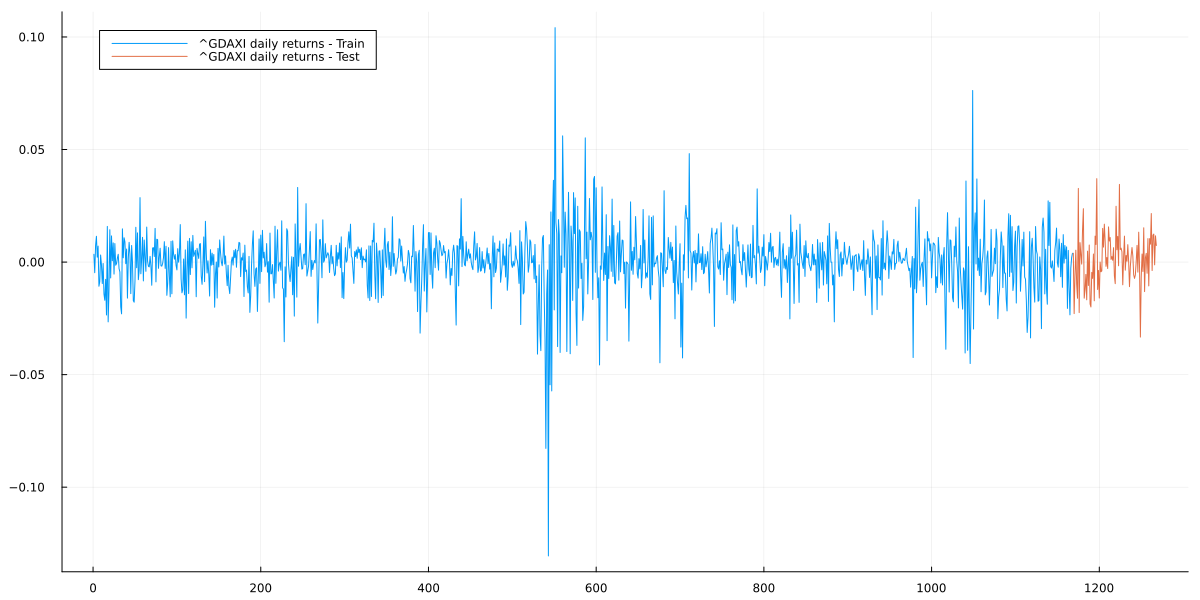

In [3]:
plot(train, label="^GDAXI daily returns - Train", size = (1200,600))
plot!(collect(length(train)+1:length(train)+100), test, label="^GDAXI daily returns - Test")

In [4]:
struct VarCoeffGARCH
    constant::Vector{Float32}
    net::Chain
    
    x0::Vector{Float32}
end
Flux.@functor VarCoeffGARCH

VarCoeffGARCH(net::Chain) = VarCoeffGARCH([-9], net, [0.0])


function garch_mean_ll(m::VarCoeffGARCH, y::Vector{Float32})
    sigmas, _ = garch_forward(m,y)
    conditional_dists = Normal.(0, sigmas)
    
    return mean(logpdf.(conditional_dists, y))
end


#Use functional implementation to calculate conditional stddev.
#Then, we don't need to store stddev_t to calculate stddev_t+1
#and thus avoid mutation, which doesn't work with Zygote
#(could use Zygote.Buffer, but it's often discouraged)
function garch_forward(m::VarCoeffGARCH, y::Vector{Float32})
    
    sigma_1, params_1 = m(m.x0[1], sqrt(softplus(m.constant[1])))
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_1, y, 1)
    
    sigmas_result = vcat(sigma_1, sigma_rec)
    params_result = hcat(params_1, params_rec)
    
    return sigmas_result, params_result
    
end

function garch_forward_recurse(m::VarCoeffGARCH, sigma_tm1::Float32, y::Vector{Float32}, t::Int64)
    
    sigma_t, params_t = m(y[t], sigma_tm1)
    
    if t==length(y)-1
        return sigma_t, params_t
    end
    
    sigma_rec, params_rec = garch_forward_recurse(m, sigma_t, y, t+1)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    params_result = hcat(params_t, params_rec)
    
    return sigmas_result, params_result
end


function (m::VarCoeffGARCH)(y::Float32, sigma::Float32)
    
    input_vec = vcat(y, sigma)
    
    params = m.net(input_vec)
    params_stable = get_garch_stable_params(params) #to ensure stationarity of the resulting GARCH process
        
    return sqrt(softplus(m.constant[1]) + sum(input_vec.^2 .* params_stable)), params_stable
end

#transform both parameters to be >0 each and their sum to be <1
get_garch_stable_params(x::Vector{Float32}) = vcat(σ(x[1]), (1-σ(x[1]))*σ(x[2]))

get_garch_stable_params (generic function with 1 method)

In [5]:
Random.seed!(123)

model = VarCoeffGARCH(Chain(Dense(2,2,softplus), Dense(2,2,softplus), Dense(2,2)))
params = Flux.params(model)

Params([Float32[-9.0], Float32[-1.1059412 -0.40677243; 0.051962912 0.21263216], Float32[0.0, 0.0], Float32[-1.1964471 0.9870632; 0.95745337 -0.757121], Float32[0.0, 0.0], Float32[-0.2198652 -0.7871106; 0.0628597 -0.26800305], Float32[0.0, 0.0], Float32[0.0]])

In [6]:
opt = ADAM(0.01)

for i in 1:500
    grads = Zygote.gradient(()->-garch_mean_ll(model, train), params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%50==0
        println(garch_mean_ll(model,train))
    end
end

2.973238
3.0015454
3.0188503
3.0298147
3.038704
3.0551393
3.0628562
3.0676363
3.0707815
3.0733144


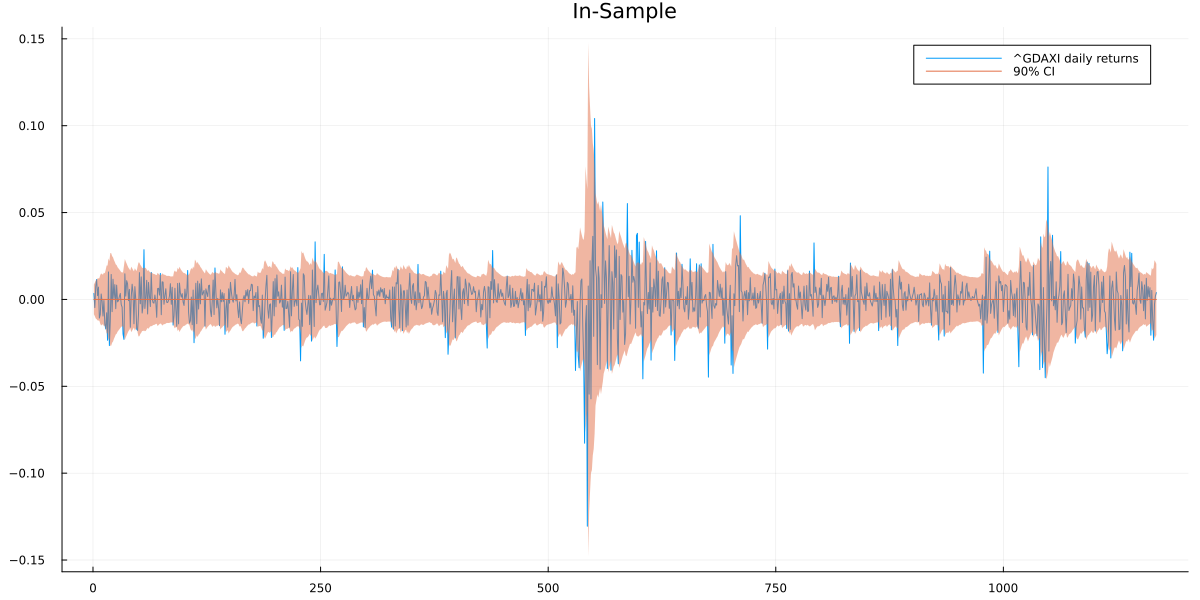

In [7]:
sigmas, params = garch_forward(model,train)

lower = quantile.(Normal.(0,sigmas),0.05)
upper = quantile.(Normal.(0,sigmas),0.95)

plot(train, label="^GDAXI daily returns", size = (1200,600), title="In-Sample")
plot!(zeros(length(lower)), ribbon=(upper,-lower),label = "90% CI")

In [8]:
function garch_forward_sample(m::VarCoeffGARCH, sigma_tm1::Float32, y_tm1::Float32, t::Int64, T::Int64=100)
    
    sigma_t, params_t = m(y_tm1, sigma_tm1)
    sample_t = randn(Float32)*sigma_t
    
    if t==T
        return sigma_t, sample_t, params_t
    end
    
    sigma_rec, sample_rec, params_rec = garch_forward_sample(m, sigma_t, sample_t, t+1, T)
    
    sigmas_result = vcat(sigma_t, sigma_rec)
    sample_result = vcat(sample_t, sample_rec)
    params_result = vcat(params_t, params_rec)
    
    return sigmas_result, sample_result, params_result
    
end

garch_forward_sample (generic function with 2 methods)

In [9]:
mc_simulation = [garch_forward_sample(model, sigmas[end], train[end], 1) for _ in 1:25000]

sigma_sample = hcat(map(x->x[1], mc_simulation)...)
y_forecast_sample = hcat(map(x->x[2], mc_simulation)...)
params1_sample = hcat(map(x->x[3], mc_simulation)...)
params2_sample = hcat(map(x->x[3], mc_simulation)...)

y_forecast_mean = mean(y_forecast_sample,dims=2)[:]
y_forecast_lower = mapslices(x->quantile(x,0.05), y_forecast_sample, dims=2)[:]
y_forecast_upper = mapslices(x->quantile(x,0.95), y_forecast_sample, dims=2)[:]

100-element Vector{Float64}:
 0.019390116073191164
 0.019138189777731896
 0.01908267755061388
 0.018804516363888975
 0.018747168034315108
 0.018414231482893225
 0.018434156198054545
 0.01820982992649078
 0.01826221533119678
 0.01828428879380226
 0.018111711647361514
 0.0182392394170165
 0.017973494250327345
 ⋮
 0.017603636719286442
 0.01771391527727246
 0.01753247445449233
 0.017581268865615125
 0.017664946615695946
 0.017426682822406284
 0.01768205231055617
 0.017574634123593565
 0.01777340546250343
 0.017421578895300625
 0.017520933877676725
 0.017338841315358875

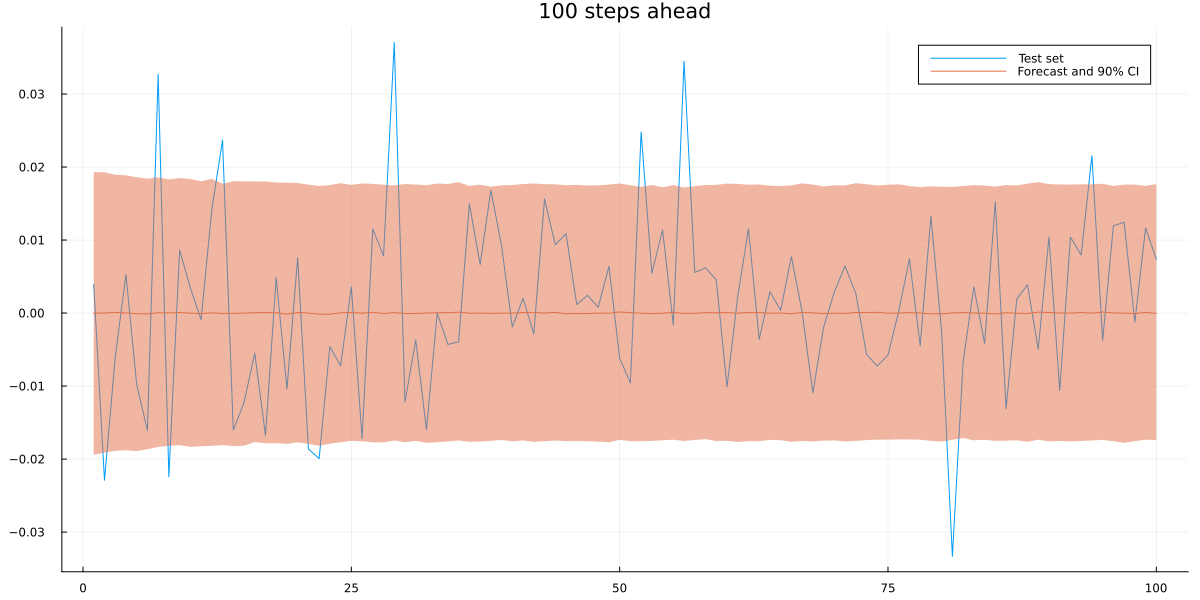

In [10]:
plot(test[1:100], size = (1200,600), title = "100 steps ahead", label="Test set")
plot!(y_forecast_mean, ribbon = (y_forecast_upper.-y_forecast_mean, y_forecast_mean.-y_forecast_lower), label="Forecast and 90% CI")

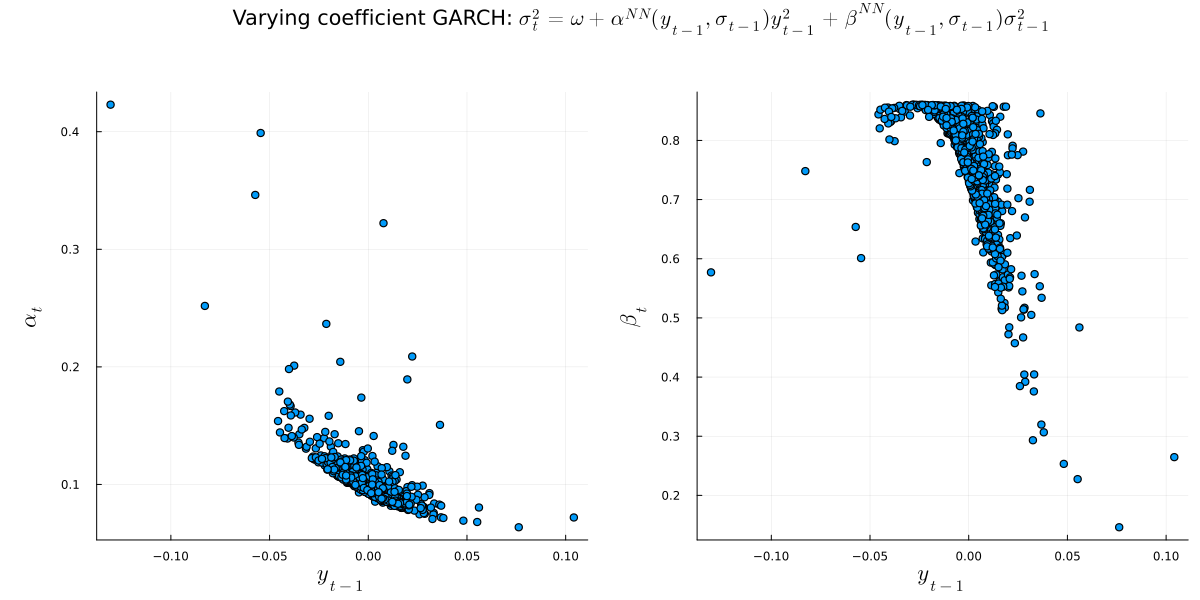

In [12]:
title = plot(title = "Varying coefficient GARCH: "*L"\sigma^2_t=\omega + \alpha^{NN}(y_{t-1},\sigma_{t-1})y^2_{t-1}+\beta^{NN}(y_{t-1},\sigma_{t-1})σ^2_{t-1}", grid = false, showaxis = false)


p1 = scatter(train[1:end-1], params[1,2:end], label=:none, guidefontsize=15)
xlabel!(p1,L"y_{t-1}")
ylabel!(p1,L"\alpha_t")


p2 = scatter(train[1:end-1], params[2,2:end], label=:none, guidefontsize=15)
xlabel!(p2,L"y_{t-1}")
ylabel!(p2,L"\beta_t")


plot(title, p1, p2, layout = @layout([A{0.01h}; [B C]]), size = (1200,600), left_margin=10*Plots.mm, bottom_margin=5*Plots.mm,fmt=:png)